# Exploratory Data Analysis (EDA)

In [2]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# import keras_core as keras
import keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2025-07-10 22:21:04.346216: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 22:21:04.435829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752182464.467753  111305 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752182464.477222  111305 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752182464.546767  111305 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
KerasNLP version: 0.21.1


/home/monkin/Desktop/llm-learn/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check Available Devices

In [4]:
# Check available devices
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

if tf.config.list_physical_devices('GPU'):
    print("TensorFlow (Keras backend) is detecting at least one GPU.")

# Enable device placement logging
LOG_DEVICE_PLACEMENT = False
if LOG_DEVICE_PLACEMENT:
    tf.debugging.set_log_device_placement(True)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow (Keras backend) is detecting at least one GPU.


In [5]:
# Clear any existing session
keras.backend.clear_session()

# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [6]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [9]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


## Check for missing values 

In [10]:
# Check for missing values on each column
print("Missing values in training set:")
print(df_train.isnull().sum())
print()
print("Missing values in test set:")
print(df_test.isnull().sum())

Missing values in training set:
id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

Missing values in test set:
id             0
keyword       26
location    1105
text           0
length         0
dtype: int64


Seems like the fields `keyword` and `location` have some missing values, but the `text`, `target`, `length` and `id` fields are complete.

Let's fill the missing values with a placeholder value.

In [12]:
missing_cols = ['keyword', 'location']

for df in [df_train, df_test]:
    for col in missing_cols:
        # Fill missing values with placeholder: 'no_<COL_NAME>'
        df[col] = df[col].fillna(f'no_{col}')

# Check again for missing values
print("Missing values in training set after filling:")
print(df_train.isnull().sum())
print()
print("Missing values in test set after filling:")
print(df_test.isnull().sum())

Missing values in training set after filling:
id          0
keyword     0
location    0
text        0
target      0
length      0
dtype: int64

Missing values in test set after filling:
id          0
keyword     0
location    0
text        0
length      0
dtype: int64


## Cardinality and `Target` Distribution

In [13]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


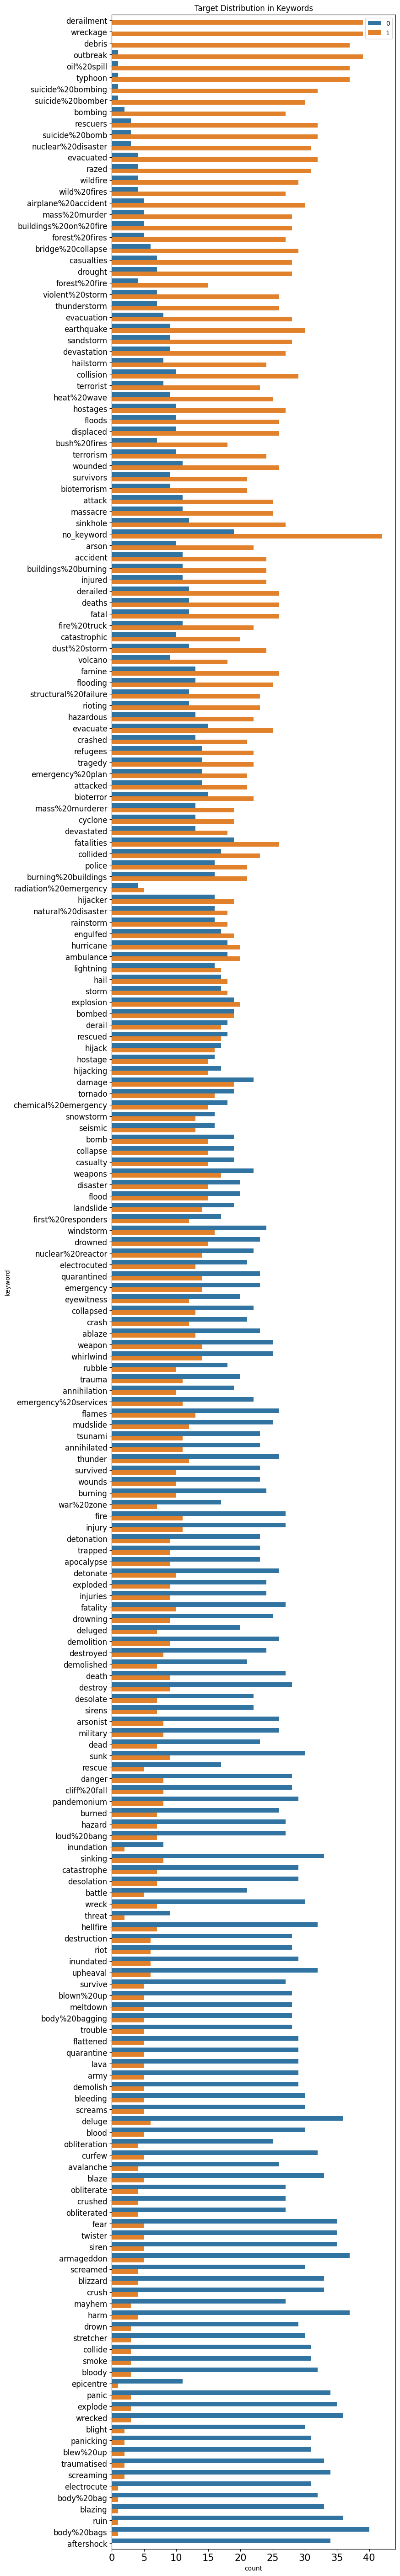

In [ ]:
# Add a new column to the Training set with the mean of the Target variable grouped by keyword
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

# Drop the 'target_mean' column after plotting
df_train.drop(columns=['target_mean'], inplace=True)

Locations are not automatically generated, they are user inputs. For this reason, there are too many unique values in the field, so we will drop it.

On the other hand, the `keyword` field has a low cardinality and we can see that some keywords are mostly associated with a target value of 0 or 1. Thus, it can be used as a feature for our model by passing the value by itself or as a word added to the text.

## Patterns from Meta Features
**Meta Features** are features derived from dataset characteristics. Distributions of meta features can reveal useful patterns in the data that can be used to improve model performance. It looks like disaster tweets are written in a more formal way, with longer words compared to non-disaster tweets, because they are more likely to be written by journalists or news agencies. Non-disaster tweets are more likely to have typos. The meta features used for this analysis are:
- **word_count**: number of words in text
- **unique_word_count**: number of unique words in text
- **stop_word_count**: number of stop words in text
- **url_count**: number of urls in text
- **mean_word_length**: average character count in words
- **char_count**: number of characters in text
- **punctuation_count**: number of punctuations in text
- **hashtag_count**: number of hashtags (#) in text
- **mention_count**: number of mentions (@) in text

----

# Preprocess the data

In [10]:
BATCH_SIZE = 32  # Batch size should be a power of 2 for better performance on GPUs
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8   # 80% training, 20% validation. The Test set is already separated.
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE  # number of training batches per epoch
print(f"Nº of training examples: {NUM_TRAINING_EXAMPLES}")
print(f"Steps per epoch: {STEPS_PER_EPOCH} (Training batches per epoch)")

EPOCHS = 4  # number of epochs to train the model
AUTO = tf.data.experimental.AUTOTUNE    

Nº of training examples: 7613
Steps per epoch: 190.0 (Training batches per epoch)


In [11]:
from sklearn.model_selection import train_test_split

X = df_train["text"]    # Feature Column
y = df_train["target"]  # Target Column

# Split the data into training and validation sets randomly
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose a DistilBERT model that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [12]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"  # Label of DistilBERT model preset

'''
Use a shorter sequence length. Sequence length is the maximum length of input sequences.
We saw above that the maximum length of a training sample is 157 characters. Thus, we can set the sequence length to 160.
'''
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,                         # Label of DistilBERT model preset
    sequence_length=160,            # Shorter sequence length for faster training. Sequence length is the maximum length of input sequences.
    name="preprocessor_4_tweets"    # Name of the preprocessor layer
)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,                         # Label of DistilBERT model preset
    preprocessor = preprocessor,    # Preprocessor layer to apply preprocessing to raw inputs during fit(), predict(), and evaluate()
    num_classes=2                   # Number of classes in the target variable (binary classification: 0 or 1) - Disaster or Not Disaster
)

classifier.summary()

I0000 00:00:1752171429.935362  335993 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5356 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Train your own model, fine-tuning BERT

In [ ]:
# Compile - Configures the Model for Training
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),  # Learning rate of 1e-5 is a good starting point for fine-tuning BERT models
    metrics= ["accuracy"]  # Using accuracy as the evaluation metric
)

# Fit - Train the Model
history = classifier.fit(x=X_train,                         # Training data
                         y=y_train,                         # Training labels
                         batch_size=BATCH_SIZE,             
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)     # Validation data
)

Epoch 1/4


2025-07-10 19:17:11.429612: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1752171436.135675  337200 service.cc:152] XLA service 0x7f06c80031f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752171436.135686  337200 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-07-10 19:17:16.309580: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752171437.230650  337200 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-10 19:17:18.929728: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 184 bytes spill stores, 184 bytes spill loads

2

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7259 - loss: 0.5647

2025-07-10 19:18:09.661493: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 28 bytes spill stores, 28 bytes spill loads

2025-07-10 19:18:09.681531: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 888 bytes spill stores, 888 bytes spill loads

2025-07-10 19:18:09.705555: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 248 bytes spill stores, 248 bytes spill loads

2025-07-10 19:18:09.779499: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_139', 240 bytes spill stores, 240 bytes spill loads

2025-07-10 19:18:09.800062: I external

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7262 - loss: 0.5643

2025-07-10 19:18:24.365712: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1929', 4 bytes spill stores, 4 bytes spill loads

2025-07-10 19:18:24.426335: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1929', 136 bytes spill stores, 176 bytes spill loads

2025-07-10 19:18:24.449359: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1929', 76 bytes spill stores, 76 bytes spill loads

2025-07-10 19:18:24.609126: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1929', 948 bytes spill stores, 948 bytes spill loads

2025-07-10 19:18:24.669642: I external

191/191 ━━━━━━━━━━━━━━━━━━━━ 80s 314ms/step - accuracy: 0.7265 - loss: 0.5639 - val_accuracy: 0.8437 - val_loss: 0.3958
Epoch 2/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - accuracy: 0.8486 - loss: 0.3760 - val_accuracy: 0.8470 - val_loss: 0.3836
Epoch 3/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 42s 219ms/step - accuracy: 0.8798 - loss: 0.3241 - val_accuracy: 0.8418 - val_loss: 0.3979
Epoch 4/4
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 214ms/step - accuracy: 0.8984 - loss: 0.2782 - val_accuracy: 0.8378 - val_loss: 0.4080


In [14]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    '''
    Displays the confusion matrix for the given true labels and predicted labels.
    '''
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, # True labels of the validation set
        np.argmax(y_pred, axis=1),  # Convert logits to class labels (predictions) by selecting the index of the maximum value along the specified axis -- Deterministic prediction.
        display_labels=["Not Disaster","Disaster"], # Define the labels for the Positive and Negative classes
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))    # Calculate F1 Score

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))    # Set the title of the confusion matrix plot


189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

2025-07-10 19:20:46.965492: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1910', 96 bytes spill stores, 96 bytes spill loads

2025-07-10 19:20:47.132135: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1910', 924 bytes spill stores, 924 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step


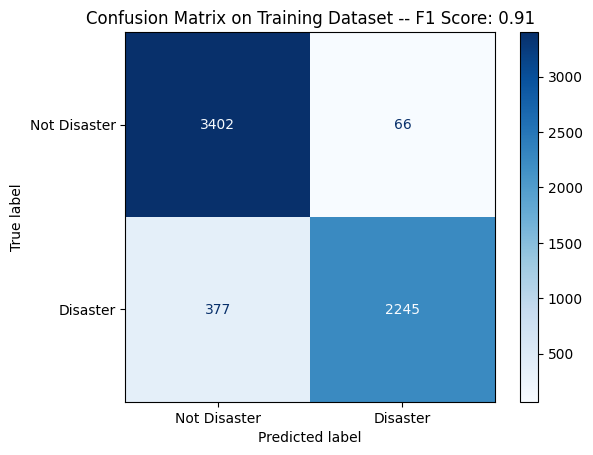

In [15]:
y_pred_train = classifier.predict(X_train)  # Predict on the training set

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step


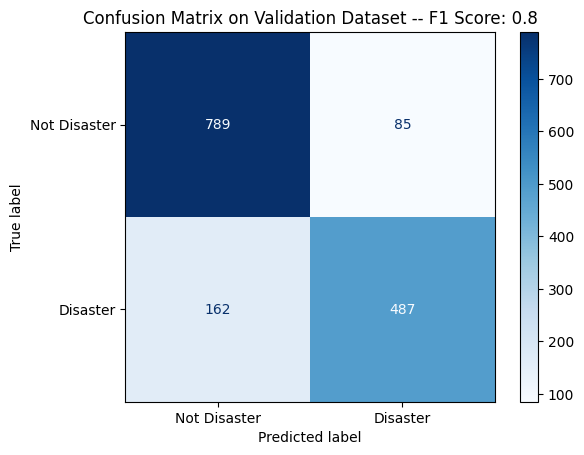

In [16]:
y_pred_val = classifier.predict(X_val)  # Predict on the validation set

displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Generate the submission file 

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [17]:
sample_submission = pd.read_csv("input/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [18]:
# Add a new column "target" to the sample_submission DataFrame with the Prediction Targets in the Test Set
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1) # Using argmax to convert logits to class labels (predictions) -- deterministic prediction.

101/102 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

2025-07-10 19:20:58.648889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 240 bytes spill stores, 240 bytes spill loads

2025-07-10 19:20:58.669778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 248 bytes spill stores, 248 bytes spill loads

2025-07-10 19:20:58.682207: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 428 bytes spill stores, 340 bytes spill loads

2025-07-10 19:20:58.689342: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 432 bytes spill stores, 344 bytes spill loads

2025-07-10 19:20:58.705163: I external/l

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step


In [19]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.361630
std,3146.427221,0.480546
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [20]:
sample_submission.to_csv("out/submission.csv", index=False)